<a href="https://colab.research.google.com/github/ZhihaoDC/TFG/blob/main/source/1%20-%20Dibujo%20del%20grafo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup environment

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

# %cd /gdrive/My Drive/TFG
#!git init

In [ ]:
#!git clone https://github.com/ZhihaoDC/TFG.git

In [218]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/My Drive/TFG

!git pull https://github.com/ZhihaoDC/TFG

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/TFG
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
From https://github.com/ZhihaoDC/TFG
 * branch            HEAD       -> FETCH_HEAD
Updating bc2cdf4..ae24b64
Fast-forward
 source/1 - Dibujo del grafo.ipynb | 6369 ++++++++++++++++++++++++++++++++-----
 1 file changed, 5525 insertions(+), 844 deletions(-)


# Marvel vs DC dataset

### Import Libraries

In [282]:
#Import libraries
import pandas as pd
import numpy as np
import re #regular expressions
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import statistics
import sklearn.metrics, sklearn.preprocessing, sklearn.feature_extraction.text

###Read files and peek

In [219]:
#Read files and peek
#We will use the following dictionary to define the types of the data, as it can all be str at the time of reading the .csv file
#my_datatypes ={'Original Title':str, 'Company':str,'Rate':float,'Metascore':np.int64, 'Minutes':np.int64, 'Release':np.int64, 'Budget':np.int64, 'Opening Weekend USA':np.int64, 'Gross USA': np.int64, 'Gross Worldwide':np.int64}

#Edited (Minutes and Budget are columns that can't be converted to int)
# my_datatypes ={'Original Title':str, 'Company':str,'Rate':float,'Metascore':int, 'Release':int, 'Opening Weekend USA':int, 'Gross USA': int, 'Gross Worldwide':int}

marvel_dc = pd.read_csv("./datasets/marvel-vs-dc/db.csv",  encoding='ISO-8859-1')

marvel_dc.head()

,Unnamed: 0,Original Title,Company,Rate,Metascore,Minutes,Release,Budget,Opening Weekend USA,Gross USA,Gross Worldwide
0,1,Iron Man,Marvel,7.9,79,126,2008,140000000,98618668,318604126,585366247
1,2,The Incredible Hulk,Marvel,6.7,61,112,2008,150000000,55414050,134806913,263427551
2,3,Iron Man 2,Marvel,7.0,57,124,2010,200000000,128122480,312433331,623933331
3,4,Thor,Marvel,7.0,57,115,2011,150000000,65723338,181030624,449326618
4,5,Captain America: The First Avenger,Marvel,6.9,66,124,2011,140000000,65058524,176654505,370569774


### Data cleaning

In [220]:
#Check read
marvel_dc.dtypes

Unnamed: 0               int64
Original Title          object
Company                 object
Rate                   float64
Metascore                int64
Minutes                 object
Release                  int64
Budget                  object
Opening Weekend USA      int64
Gross USA                int64
Gross Worldwide          int64
dtype: object

In [221]:
#Convert column dtypes to more suitable dtypes
marvel_dc['Original Title'] = marvel_dc['Original Title'].astype(str)
marvel_dc['Company'] = marvel_dc['Company'].astype(str)
marvel_dc['Minutes'] = marvel_dc['Minutes'].astype(np.int64)
marvel_dc['Budget'] = marvel_dc['Budget'].astype(np.int64)
marvel_dc.dtypes

Unnamed: 0               int64
Original Title          object
Company                 object
Rate                   float64
Metascore                int64
Minutes                  int64
Release                  int64
Budget                   int64
Opening Weekend USA      int64
Gross USA                int64
Gross Worldwide          int64
dtype: object

We can see that 'Original Title' and 'Company' have remained as 'object' types, instead of 'str'.

This may hint at some characters that have not been decoded properly

In [222]:
print(marvel_dc['Original Title'])

0                                Iron Man
1                     The Incredible Hulk
2                              Iron Man 2
3                                    Thor
4      Captain America: The First Avenger
5                            The Avengers
6                          Iron Man Three
7                    Thor: The Dark World
8     Captain America: The Winter Soldier
9                 Guardians of the Galaxy
10               Avengers: Age of Ultron 
11                                Ant-Man
12             Captain America: Civil War
13                         Doctor Strange
14         Guardians of the Galaxy Vol. 2
15                 Spider-Man: Homecoming
16                          Thor:Ragnarok
17                          Black Panther
18                 Avengers: Infinity War
19                   Ant-Man and the Wasp
20                          Captain Marve
21                      Avengers: Endgame
22              Spider-Man: Far from Home
23                               C

We can see some blank spaces trailing in movie titles like "Suicide Squad ", "Avengers: Age of Ultron ", "Jonah Hex " 

In [223]:
marvel_dc['Original Title'] = marvel_dc['Original Title'].str.strip()
marvel_dc['Original Title'] = marvel_dc['Original Title'].str.replace("  "," ") #Check for double spaces
marvel_dc[marvel_dc['Original Title'] == 'Suicide Squad']

,Unnamed: 0,Original Title,Company,Rate,Metascore,Minutes,Release,Budget,Opening Weekend USA,Gross USA,Gross Worldwide
33,34,Suicide Squad,DC,6.0,40,123,2016,175000000,133682248,325100054,746846894


We can do the same for the column 'Company'

In [224]:
marvel_dc['Company'] = marvel_dc['Company'].str.strip()

We can also replace the spaces in the variable names

In [225]:
new_columns = [column.replace(" ", "_") for column in marvel_dc.columns]
print(new_columns)

#Out: ['Original_Title', 'Company', 'Rate', 'Metascore', 'Minutes', 'Release', 'Budget', 'Opening_Weekend_USA', 'Gross\xa0USA', 'Gross_Worldwide']
#Look at'Gross\xa0USA'
#This will result in an error if we tried to execute marvel_dc['Gross USA']

['Unnamed:_0', 'Original_Title', 'Company', 'Rate', 'Metascore', 'Minutes', 'Release', 'Budget', 'Opening_Weekend_USA', 'Gross\xa0USA', 'Gross_Worldwide']


As we can see, we have an unknown character '\xa0' disguised as an space

In [226]:
marvel_dc.columns = marvel_dc.columns.str.normalize('NFKC')
print(marvel_dc.columns)
#Now we can execute 
#marvel_dc['Gross USA']

Index(['Unnamed: 0', 'Original Title', 'Company', 'Rate', 'Metascore',
       'Minutes', 'Release', 'Budget', 'Opening Weekend USA', 'Gross USA',
       'Gross Worldwide'],
      dtype='object')


In [227]:
#Replace spaces in column names
marvel_dc.columns = [column.replace(" ", "_") for column in marvel_dc.columns]
print(marvel_dc.columns)

Index(['Unnamed:_0', 'Original_Title', 'Company', 'Rate', 'Metascore',
       'Minutes', 'Release', 'Budget', 'Opening_Weekend_USA', 'Gross_USA',
       'Gross_Worldwide'],
      dtype='object')


In [228]:
marvel_dc['Original_Title'] = marvel_dc['Original_Title'].astype(str)
marvel_dc['Company'] = marvel_dc['Company'].astype(str)

In [229]:
#Search for null values
null_values=pd.DataFrame(data=marvel_dc.isnull().any(), columns={'has_null_values'})
null_values

,has_null_values
Unnamed:_0,False
Original_Title,False
Company,False
Rate,False
Metascore,False
Minutes,False
Release,False
Budget,False
Opening_Weekend_USA,False
Gross_USA,False


In [230]:
#Drop non useful columns
marvel_dc = marvel_dc.drop(columns= 'Unnamed:_0')
marvel_dc.head()

,Original_Title,Company,Rate,Metascore,Minutes,Release,Budget,Opening_Weekend_USA,Gross_USA,Gross_Worldwide
0,Iron Man,Marvel,7.9,79,126,2008,140000000,98618668,318604126,585366247
1,The Incredible Hulk,Marvel,6.7,61,112,2008,150000000,55414050,134806913,263427551
2,Iron Man 2,Marvel,7.0,57,124,2010,200000000,128122480,312433331,623933331
3,Thor,Marvel,7.0,57,115,2011,150000000,65723338,181030624,449326618
4,Captain America: The First Avenger,Marvel,6.9,66,124,2011,140000000,65058524,176654505,370569774


###Variable preview

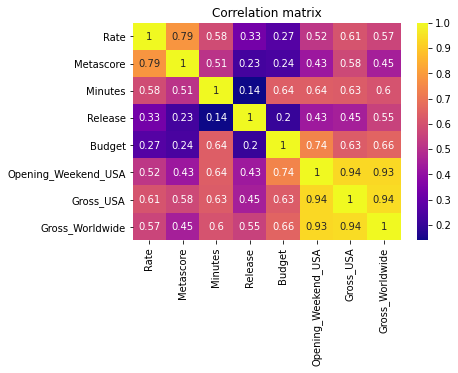

In [268]:
corr_matrix= marvel_dc.drop(columns=['Original_Title']).corr()
sb.heatmap(corr_matrix, annot=True, cmap='plasma')
plt.title('Correlation matrix')
plt.show()

We can see that those variables related to reputation of the film as 'score' or 'metascore' are highly correlated.

However a more noteworthy observation is the high correlation between those variables that imply profits made from the film, since one is a subset of the other, which is also a subset of the other.

Also, the variables that imply profit are also highly correlated with the rest, since a good film is generally likely to have good ratings and budget.

We can guess that two powerful variables can be Metascore and Gross_Worldwide

Budget has an average budget of 184.10 million dollars


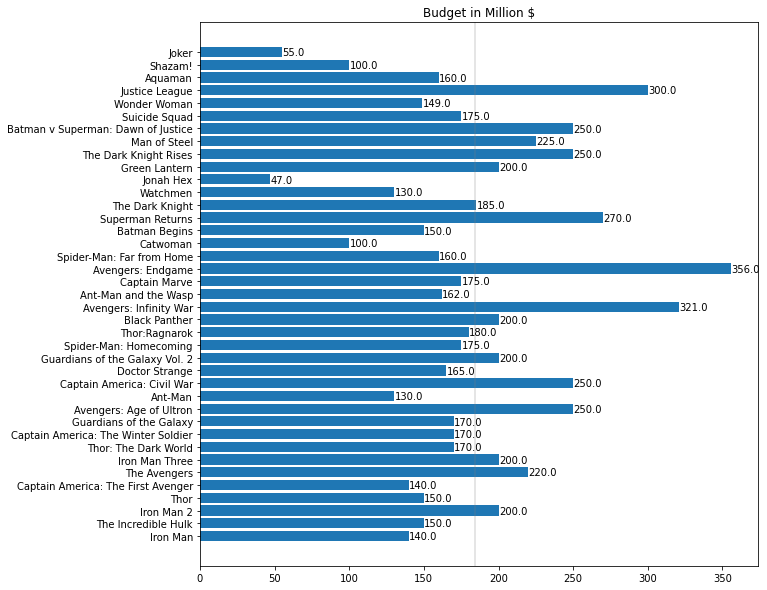

In [274]:
budget_millions = marvel_dc['Budget']/1000000

AVG_BUDGET = statistics.mean(budget_millions)
print('Budget has an average budget of', format(AVG_BUDGET,'.2f') , 'million dollars' )

plt.figure(figsize=(10,10))
ax= plt.subplot(111)

ax.barh(y=marvel_dc['Original_Title'], width=budget_millions)

for count, value in enumerate(budget_millions):
    ax.text(x= value+0.25, y= count-0.25, s= value)

ax.axvline(x=AVG_BUDGET, color='grey', linewidth=0.4)
    
plt.title('Budget in Million $')
plt.show()

The average rating for a marvel/dc movie is 7.202564102564103


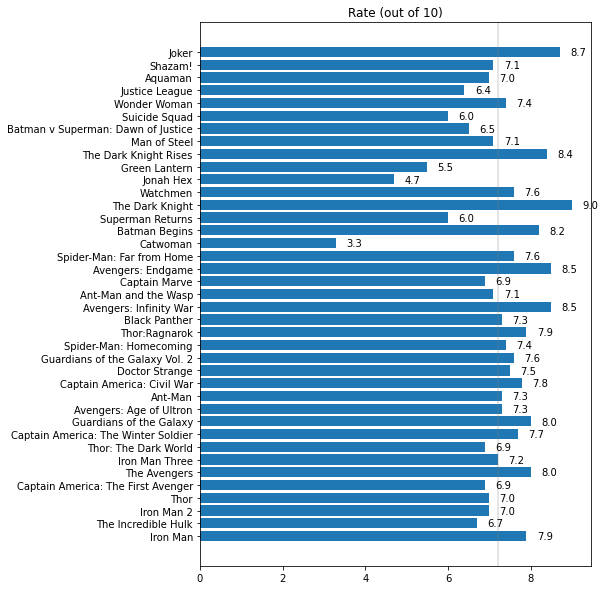

In [233]:
plt.figure(figsize=(7,10))
ax= plt.subplot(111)

AVG_RATE = statistics.mean(marvel_dc['Rate'])
print("The average rating for a marvel/dc movie is",AVG_RATE)

ax.barh(y=marvel_dc['Original_Title'], width=marvel_dc['Rate'], )

for count, value in enumerate(marvel_dc['Rate']):
    ax.text(x= value+0.25, y= count-0.25, s= value)

ax.axvline(AVG_RATE, color='grey', linewidth=0.4)
    
plt.title('Rate (out of 10)')
plt.show()

The average earnings for a marvel/dc movie is 827.5726761538461


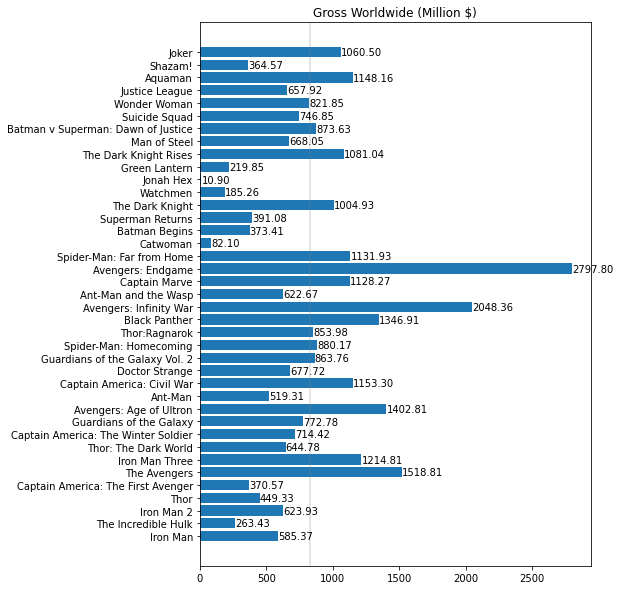

In [234]:
gross_wrld_millions = marvel_dc['Gross_Worldwide'] / 1000000
AVG_GROSS_WRLD = statistics.mean(gross_wrld_millions)
print("The average earnings for a marvel/dc movie is",AVG_GROSS_WRLD)

plt.figure(figsize=(7,10))
ax= plt.subplot(111)

ax.barh(y=marvel_dc['Original_Title'], width=gross_wrld_millions, )

for count, value in enumerate(gross_wrld_millions):
    ax.text(x= value+0.25, y= count-0.25, s= format(value,'.2f'))

ax.axvline(AVG_GROSS_WRLD, color='grey', linewidth=0.4)
    
plt.title('Gross Worldwide (Million $)')
plt.show()

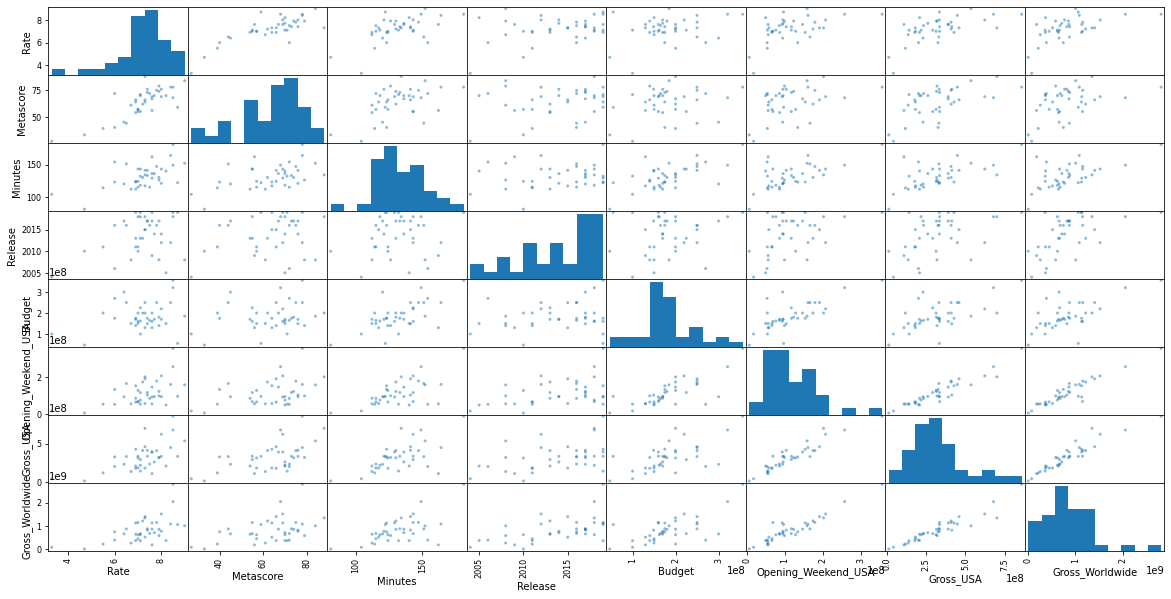

In [279]:
pd.plotting.scatter_matrix(marvel_dc.drop(columns=['Original_Title']), figsize=(20,10))
plt.show()

In [288]:
px.scatter_matrix(marvel_dc.drop(columns=['Company']),width=1800, height=1600)

### Data preparation

####Encoding

Now, we need a similarity measure, but in order to use all the variables possible, we need to encode them.



In [235]:
def encode_company(companies):
  encoded_companies = []

  for company in companies:
    if company == 'Marvel':
      encoded_companies.append(0)
    elif company == 'DC':
      encoded_companies.append(1)
    else:
      encoded_companies.append(np.nan)
      
  return encoded_companies

In [236]:
#Create a copy of the dataset and add encoded columns
marvel_dc_copy = marvel_dc.copy()
marvel_dc_copy['0:_Marvel_1:_DC'] = encode_company(marvel_dc['Company'])

In [276]:
#Drop no encoded columns
marvel_dc_nostr = marvel_dc_copy.drop(columns=['Original_Title','Company'])
plt.show()

####Bag of words

We don't want to lose the relationship that some movie titles. We can apply a process commonly known as 'Bag of Words' in which we count the number of occurences of all the words. This results in a vector that is called a 'vocabulary'.

Using a vocabulary enables us to link prequels to sequels, since many of them share certain keywords like 'Iron Man' in 'Iron Man', 'Iron Man 2', etc.

(We can also ignore some irrelevant words that convey no meaning at all, like words like 'the', punctuation notes, etc.)


To carry out this little analysis, we will be depending on sklearn's CountVectorizer, which gives us the exact same funtionality as mentioned above

In [239]:
# mystop_words =['the','of','man','and','volume','vol','part','pt','1','2','3','4','5','one','two','three','four','five']
# vectorizer = sklearn.feature_extraction.text.CountVectorizer(min_df=2)
# vectorizer.fit(marvel_dc['Original_Title'])
# vocabulary_values = vectorizer.transform(marvel_dc['Original_Title']).toarray()
# vocabulary = vectorizer.get_feature_names()

# print(vocabulary)

In [240]:
def get_hero_name (movie_title):
  """Get hero name from movie title, removing spaces or dashes in cases like 'Iron Man' or 'Ant-Man' """

  hero_name = movie_title.split(':')[0] #Get hero name

  hero_name = re.sub(r'.Man','Man',hero_name) #Clean hero name from spaces or dash
  #'.Man' <-- regexp corresponds to one character followed by 'Man'

  return hero_name

In [241]:
hero_names = marvel_dc['Original_Title'].apply(lambda x: get_hero_name(x))
print(hero_names)

0                            IronMan
1                The Incredible Hulk
2                          IronMan 2
3                               Thor
4                    Captain America
5                       The Avengers
6                      IronMan Three
7                               Thor
8                    Captain America
9            Guardians of the Galaxy
10                          Avengers
11                            AntMan
12                   Captain America
13                    Doctor Strange
14    Guardians of the Galaxy Vol. 2
15                         SpiderMan
16                              Thor
17                     Black Panther
18                          Avengers
19               AntMan and the Wasp
20                     Captain Marve
21                          Avengers
22                         SpiderMan
23                          Catwoman
24                     Batman Begins
25                  Superman Returns
26                   The Dark Knight
2

In [242]:
mystop_words =['the','of','man','and','volume','vol','part','pt','1','2','3','4','5','one','two','three','four','five']
#We might want to use only those features that connect two diferent movies --> min_df=2
vectorizer = sklearn.feature_extraction.text.CountVectorizer(min_df=2, stop_words=mystop_words) 
vectorizer.fit(hero_names)
vocabulary_values = vectorizer.transform(hero_names).toarray()
vocabulary = vectorizer.get_feature_names()

print(vocabulary)

['america', 'antman', 'avengers', 'batman', 'captain', 'dark', 'galaxy', 'guardians', 'ironman', 'knight', 'spiderman', 'superman', 'thor']


In [243]:
bagOfWords = pd.DataFrame(data=vocabulary_values, columns=vocabulary)
bagOfWords.head(10)
#len(values.columns) #13

,america,antman,avengers,batman,captain,dark,galaxy,guardians,ironman,knight,spiderman,superman,thor
0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,1,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,1
8,1,0,0,0,1,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,1,0,0,0,0,0


In [244]:
#Idea
# titles_sequel = marvel_dc['Original_Title'].str.find(':')
# bool_find = titles_sequel > 0

In [245]:
marvel_dc_nostr_bow=pd.concat([marvel_dc_nostr, bagOfWords], axis=1)
marvel_dc_nostr_bow.head()

,Rate,Metascore,Minutes,Release,Budget,Opening_Weekend_USA,Gross_USA,Gross_Worldwide,0:_Marvel_1:_DC,america,antman,avengers,batman,captain,dark,galaxy,guardians,ironman,knight,spiderman,superman,thor
0,7.9,79,126,2008,140000000,98618668,318604126,585366247,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,6.7,61,112,2008,150000000,55414050,134806913,263427551,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7.0,57,124,2010,200000000,128122480,312433331,623933331,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,7.0,57,115,2011,150000000,65723338,181030624,449326618,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,6.9,66,124,2011,140000000,65058524,176654505,370569774,0,1,0,0,0,1,0,0,0,0,0,0,0,0


####Standarize data

In order to find a proper similarity measure, we need to normalize the data, since variables with larger-order of magnitudes might dominate (or have too much of an influence) our similarity measure

We will be using sklearn.preprocessing.StandardScaler() for this process, which uses a standard score of a sample x, calculated as:

z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

In [246]:
#Scale data with sklearn
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(marvel_dc_nostr)

#print means
means = ['{0:0.2f}'.format(mean) for mean in scaler.mean_]
print(means)

#print variances
variances = ['{0:0.2f}'.format(var) for var in scaler.var_]
print(variances)

#transform the dataset into scaled dataset
marvel_dc_transformed = scaler.transform(marvel_dc_nostr) 

#display scaled dataset
marvel_dc_scaled = pd.DataFrame(data=marvel_dc_transformed, columns=marvel_dc_nostr.columns, index=marvel_dc['Original_Title'])
display(marvel_dc_scaled)
#print(df_scaled.loc['Avengers: Endgame'])

['7.20', '63.67', '131.85', '2013.79', '184102564.10', '115109770.31', '323265922.87', '827572676.15', '0.41']
['1.13', '187.20', '331.41', '17.91', '4042297172912558.00', '4594265917994789.00', '31818266288807104.00', '277045486308681056.00', '0.24']


,Rate,Metascore,Minutes,Release,Budget,Opening_Weekend_USA,Gross_USA,Gross_Worldwide,0:_Marvel_1:_DC
Original_Title,,,,,,,,,
Iron Man,0.657438,1.120695,-0.321134,-1.369420,-0.693665,-0.243300,-0.026135,-0.460161,-0.834058
The Incredible Hulk,-0.473742,-0.194904,-1.090165,-1.369420,-0.536380,-0.880714,-1.056522,-1.071804,-0.834058
Iron Man 2,-0.190947,-0.487259,-0.430995,-0.896789,0.250042,0.191982,-0.060729,-0.386889,-0.834058
Thor,-0.190947,-0.487259,-0.925372,-0.660473,-0.536380,-0.728617,-0.797387,-0.718619,-0.834058
Captain America: The First Avenger,-0.285212,0.170541,-0.430995,-0.660473,-0.693665,-0.738426,-0.821920,-0.868247,-0.834058
The Avengers,0.751703,0.389807,0.612689,-0.424157,0.564611,1.362165,1.682349,1.313268,-0.834058
Iron Man Three,-0.002417,-0.121815,-0.101411,-0.187841,0.250042,0.870964,0.480713,0.735704,-0.834058
Thor: The Dark World,-0.285212,-0.706525,-1.090165,-0.187841,-0.221811,-0.433336,-0.655376,-0.347277,-0.834058
Captain America: The Winter Soldier,0.468908,0.462896,0.228174,0.048475,-0.221811,-0.296337,-0.355984,-0.214973,-0.834058


A little interpretation of what we have in the prior figure is that, taken a row such as 'Avengers: Endgame':

    Rate                   1.223029
    Metascore              1.047607
    Minutes                2.700059
    Release                1.230055
    Budget                 2.703680
    Opening_Weekend_USA    3.570399
    Gross_USA              2.999870
    Gross_Worldwide        3.743182
    0:_Marvel_1:_DC       -0.834058
    Name: Avengers: Endgame, dtype: float64

We can see that Rate is 1.223029 which means that this observation has a rate that is 1.223029 standard deviations away from the average rate

Rate has a variance of ~1.13

Which would mean that Avengers: Endgame has 1.223029 · 1.13 = 1,38202277~ above the average (7.20) which means that 1,38202277 + 7.20 = 8,58202277~ is the rate of 'Avengers: Endgame'.

The same goes for Catwoman which has a rate of -3.678755 · 1.13 = 

Although we have pretty reasonable results, we have observed that the great variability on the data (such as the one in columns 'Budget' or 'Minutes') causes still some notable variability in the standarized data. This variability can make some columns to 'dominate' with its influence on the similarity measure.

We can tackle this by standarizing the data in a way that it ranges from 0 to 1.

In [247]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
scaler.fit(marvel_dc_nostr)

marvel_dc_std = scaler.transform(marvel_dc_nostr)

marvel_dc_std = pd.DataFrame(data=marvel_dc_std, index=marvel_dc['Original_Title'], columns=marvel_dc_nostr.columns)
marvel_dc_std

,Rate,Metascore,Minutes,Release,Budget,Opening_Weekend_USA,Gross_USA,Gross_Worldwide,0:_Marvel_1:_DC
Original_Title,,,,,,,,,
Iron Man,0.807018,0.852459,0.45,0.266667,0.300971,0.265083,0.363349,0.206130,0.0
The Incredible Hulk,0.596491,0.557377,0.31,0.266667,0.333333,0.142251,0.146563,0.090611,0.0
Iron Man 2,0.649123,0.491803,0.43,0.400000,0.495146,0.348964,0.356071,0.219969,0.0
Thor,0.649123,0.491803,0.34,0.466667,0.333333,0.171561,0.201083,0.157316,0.0
Captain America: The First Avenger,0.631579,0.639344,0.43,0.466667,0.300971,0.169670,0.195922,0.129056,0.0
The Avengers,0.824561,0.688525,0.62,0.533333,0.559871,0.574464,0.722803,0.541071,0.0
Iron Man Three,0.684211,0.573770,0.49,0.600000,0.495146,0.479807,0.469987,0.431989,0.0
Thor: The Dark World,0.631579,0.442623,0.31,0.600000,0.398058,0.228463,0.230961,0.227450,0.0
Captain America: The Winter Soldier,0.771930,0.704918,0.55,0.666667,0.398058,0.254863,0.293951,0.252438,0.0


### Cosine similarity

We can now use a similarity measure like the cosin similarity, which computes similarity as the normalized dot product of X and Y:

K(X, Y) = <X,Y> / (||X||*||Y||)

In [248]:
movie_1 = marvel_dc_scaled.loc[marvel_dc_scaled.index == 'The Dark Knight Rises']
movie_2 = marvel_dc_scaled.loc[marvel_dc_scaled.index == 'Catwoman']
example = pd.concat([movie_1,movie_2])
display(example)

similarity = sklearn.metrics.pairwise.cosine_similarity(movie_1, movie_2)
movie_titles = [title for title in example.index]
print(movie_titles, similarity, sep=' ')

### Output examples
#['The Dark Knight Rises', 'Catwoman'] [[-0.60190217]] 
#['Avengers: Infinity War', 'Catwoman'] [[-0.76370355]]
#['Avengers: Infinity War', 'Avengers: Endgame'] [[0.97139774]]
#['Avengers: Infinity War', 'Justice League'] [[-0.05384619]]
#['The Avengers', 'Justice League'] [[-0.40653774]]
#['Avengers: Infinity War', 'Suicide Squad'] [[-0.24579913]]

,Rate,Metascore,Minutes,Release,Budget,Opening_Weekend_USA,Gross_USA,Gross_Worldwide,0:_Marvel_1:_DC
Original_Title,,,,,,,,,
The Dark Knight Rises,1.128764,1.047607,1.766236,-0.424157,1.036464,0.675374,0.700053,0.481558,1.198958
Catwoman,-3.678755,-2.679924,-1.529611,-2.314684,-1.322803,-1.451459,-1.586886,-1.416299,1.198958


['The Dark Knight Rises', 'Catwoman'] [[-0.60190217]]


In [249]:
similarity = sklearn.metrics.pairwise.cosine_similarity(marvel_dc_scaled)
similarity_matrix = pd.DataFrame(similarity, index=marvel_dc_std.index, columns=marvel_dc_std.index)

similarity_matrix.style.background_gradient(cmap='plasma')

Original_Title,Iron Man,The Incredible Hulk,Iron Man 2,Thor,Captain America: The First Avenger,The Avengers,Iron Man Three,Thor: The Dark World,Captain America: The Winter Soldier,Guardians of the Galaxy,Avengers: Age of Ultron,Ant-Man,Captain America: Civil War,Doctor Strange,Guardians of the Galaxy Vol. 2,Spider-Man: Homecoming,Thor:Ragnarok,Black Panther,Avengers: Infinity War,Ant-Man and the Wasp,Captain Marve,Avengers: Endgame,Spider-Man: Far from Home,Catwoman,Batman Begins,Superman Returns,The Dark Knight,Watchmen,Jonah Hex,Green Lantern,The Dark Knight Rises,Man of Steel,Batman v Superman: Dawn of Justice,Suicide Squad,Wonder Woman,Justice League,Aquaman,Shazam!,Joker
Original_Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Iron Man,1.000000,0.570539,0.401318,0.457013,0.633580,0.095872,0.031987,0.185320,0.621158,0.714622,-0.217530,0.390887,-0.044950,0.417230,-0.070769,0.187338,0.281142,0.045389,-0.272957,0.145476,-0.308103,-0.263302,-0.045953,-0.056996,0.555047,0.097290,0.383497,0.142275,-0.022065,-0.283910,-0.027946,-0.534105,-0.844327,-0.726629,-0.149155,-0.732779,-0.696029,-0.092695,-0.098219
The Incredible Hulk,0.570539,1.000000,0.683121,0.956715,0.934538,-0.564206,-0.266932,0.809597,0.318240,0.272614,-0.622503,0.716230,-0.629637,0.462039,-0.483093,-0.206206,-0.184554,-0.610580,-0.771006,0.370369,-0.387825,-0.819047,-0.325806,0.673191,0.429822,0.249124,-0.391854,0.286062,0.697440,0.550172,-0.661863,-0.240463,-0.505797,-0.046976,-0.559412,-0.062787,-0.487147,0.104529,-0.223878
Iron Man 2,0.401318,0.683121,1.000000,0.657858,0.517081,0.061764,0.387538,0.655704,0.127158,0.103966,0.038042,0.225273,-0.137869,0.101719,-0.082004,-0.225777,-0.196918,-0.258414,-0.150768,-0.031171,-0.121289,-0.233919,-0.375103,0.410828,0.069269,0.111609,-0.271614,-0.069518,0.280128,0.308300,-0.427814,-0.191000,-0.185135,-0.032858,-0.898096,-0.008495,-0.743666,-0.596129,-0.583282
Thor,0.457013,0.956715,0.657858,1.000000,0.910435,-0.577704,-0.224298,0.920648,0.362098,0.303702,-0.603491,0.830896,-0.636639,0.557045,-0.357328,-0.106876,-0.080418,-0.619333,-0.732794,0.497456,-0.215531,-0.817583,-0.135825,0.629090,0.267629,0.014819,-0.547771,0.205031,0.720818,0.529940,-0.799486,-0.324081,-0.495050,0.027784,-0.608700,-0.030551,-0.391120,0.133312,-0.075534
Captain America: The First Avenger,0.633580,0.934538,0.517081,0.910435,1.000000,-0.577547,-0.333397,0.717730,0.565559,0.405268,-0.630941,0.829793,-0.525679,0.588508,-0.309524,0.065130,0.045545,-0.504775,-0.785975,0.538682,-0.300641,-0.797862,-0.110605,0.517305,0.390904,0.170022,-0.381188,0.335294,0.576635,0.357612,-0.636110,-0.385737,-0.622037,-0.218571,-0.397460,-0.267995,-0.438385,0.274875,-0.139020
The Avengers,0.095872,-0.564206,0.061764,-0.577704,-0.577547,1.000000,0.833190,-0.496854,-0.017280,0.134953,0.871741,-0.620330,0.772638,-0.327867,0.579308,0.254952,0.269501,0.767674,0.883029,-0.472186,0.376754,0.890679,0.232760,-0.659133,-0.311174,-0.279574,0.541929,-0.501377,-0.785685,-0.756048,0.535770,-0.237789,0.019956,-0.395455,-0.043032,-0.406538,-0.278003,-0.765755,-0.192904
Iron Man Three,0.031987,-0.266932,0.387538,-0.224298,-0.333397,0.833190,1.000000,-0.027052,-0.019725,0.106606,0.853796,-0.347729,0.620459,-0.114267,0.559688,0.269363,0.243641,0.602504,0.742329,-0.223228,0.579034,0.706407,0.236610,-0.366602,-0.561523,-0.428506,0.065056,-0.678354,-0.474577,-0.502259,0.065763,-0.420878,-0.007712,-0.191761,-0.461868,-0.269568,-0.441213,-0.839664,-0.320973
Thor: The Dark World,0.185320,0.809597,0.655704,0.920648,0.717730,-0.496854,-0.027052,1.000000,0.208733,0.228568,-0.399427,0.776168,-0.535289,0.578846,-0.197471,-0.043538,-0.028690,-0.515788,-0.532979,0.562324,0.078177,-0.666956,0.010072,0.579766,-0.075712,-0.200095,-0.756025,-0.088295,0.700444,0.540115,-0.911569,-0.358208,-0.345221,0.205195,-0.718965,0.175425,-0.327055,0.014626,-0.074529
Captain America: The Winter Soldier,0.621158,0.318240,0.127158,0.362098,0.565559,-0.017280,-0.019725,0.208733,1.000000,0.749859,-0.044046,0.593504,0.266710,0.655

Although we have pretty reasonable results, we have observed that the great variability on the data (such as the one in columns 'Budget' or 'Minutes') causes still some notable variability in the standarized data. This variability can make some columns to 'dominate' with its influence on the similarity measure.

We can tackle this by standarizing the data in a way that it ranges from 0 to 1.

### Cosin similarity (standarized [0,1] data)

We will be using MinMaxScaler from sklearn, which computes 

$X_{std} = \frac{X - min(X)}{max(X) - min(X)}$

$X_{scaled} = X_{std} * (upperRangeLimit - lowerRangeLimit) + lowerRangeLimit $


where upperRangeLimit=1 and lowerRangeLimit=0 (because we need the range to be between 0 and 1)

Reference: [MinMaxScaler from Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)

Now we have normalized our data and it has an standard range. Let's calculate the cosin similarity again.

In [250]:
movie_1 = marvel_dc_std.loc[marvel_dc_std.index == 'The Avengers']
movie_2 = marvel_dc_std.loc[marvel_dc_std.index == 'Justice League']
example = pd.concat([movie_1,movie_2])
display(example)

similarity = sklearn.metrics.pairwise.cosine_similarity(movie_1, movie_2)
titles = [title for title in example.index]
print(titles, similarity)
### Output examples
#['The Dark Knight Rises', 'Catwoman'] [[0.60802022]]
#['Avengers: Infinity War', 'Catwoman'] [[0.16103361]]
#['Avengers: Infinity War', 'Avengers: Endgame'] [[0.99176472]]
#['Avengers: Infinity War', 'Justice League'] [[0.76356807]]
#['The Avengers', 'Justice League'] [[0.70729796]]
#['Avengers: Infinity War', 'Suicide Squad'] [[0.74969782]]

,Rate,Metascore,Minutes,Release,Budget,Opening_Weekend_USA,Gross_USA,Gross_Worldwide,0:_Marvel_1:_DC
Original_Title,,,,,,,,,
The Avengers,0.824561,0.688525,0.62,0.533333,0.559871,0.574464,0.722803,0.541071,0.0
Justice League,0.543860,0.295082,0.39,0.866667,0.818770,0.251504,0.257691,0.232165,1.0


['The Avengers', 'Justice League'] [[0.70729796]]


In [251]:
similarity = sklearn.metrics.pairwise.cosine_similarity(marvel_dc_std)
similarity_matrix = pd.DataFrame(similarity, index=marvel_dc_std.index, columns=marvel_dc_std.index)

similarity_matrix.style.background_gradient(cmap='plasma')

Original_Title,Iron Man,The Incredible Hulk,Iron Man 2,Thor,Captain America: The First Avenger,The Avengers,Iron Man Three,Thor: The Dark World,Captain America: The Winter Soldier,Guardians of the Galaxy,Avengers: Age of Ultron,Ant-Man,Captain America: Civil War,Doctor Strange,Guardians of the Galaxy Vol. 2,Spider-Man: Homecoming,Thor:Ragnarok,Black Panther,Avengers: Infinity War,Ant-Man and the Wasp,Captain Marve,Avengers: Endgame,Spider-Man: Far from Home,Catwoman,Batman Begins,Superman Returns,The Dark Knight,Watchmen,Jonah Hex,Green Lantern,The Dark Knight Rises,Man of Steel,Batman v Superman: Dawn of Justice,Suicide Squad,Wonder Woman,Justice League,Aquaman,Shazam!,Joker
Original_Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Iron Man,1.000000,0.979537,0.945556,0.952255,0.968211,0.927586,0.919770,0.908871,0.951506,0.962543,0.899287,0.910651,0.926578,0.920413,0.909673,0.919996,0.928015,0.910872,0.868666,0.879257,0.855718,0.853370,0.885348,0.123704,0.774453,0.720431,0.865022,0.711956,0.248658,0.527867,0.845511,0.735371,0.668809,0.605991,0.793532,0.621204,0.705077,0.708929,0.721555
The Incredible Hulk,0.979537,1.000000,0.956750,0.978777,0.984714,0.904047,0.917051,0.942746,0.968160,0.970468,0.904954,0.939720,0.939214,0.946354,0.926144,0.934291,0.945572,0.890231,0.871469,0.913549,0.866205,0.840170,0.898871,0.135232,0.769433,0.738674,0.837846,0.728195,0.278448,0.580142,0.845485,0.760269,0.700158,0.630203,0.794954,0.683743,0.723787,0.735473,0.723236
Iron Man 2,0.945556,0.956750,1.000000,0.972141,0.957133,0.978898,0.985007,0.968742,0.970215,0.964807,0.980942,0.923996,0.986225,0.939427,0.971634,0.956351,0.960393,0.946316,0.969571,0.913704,0.931666,0.952177,0.930918,0.164341,0.723883,0.728275,0.844524,0.708600,0.266359,0.616409,0.873262,0.802845,0.788057,0.715252,0.810794,0.747186,0.768802,0.715723,0.739787
Thor,0.952255,0.978777,0.972141,1.000000,0.990075,0.930967,0.955870,0.988538,0.993757,0.990760,0.947272,0.982253,0.971890,0.983162,0.976024,0.978344,0.986218,0.929916,0.923747,0.965379,0.938968,0.888392,0.962562,0.133033,0.729893,0.698713,0.821688,0.725987,0.324379,0.613655,0.850824,0.789842,0.758927,0.704528,0.831073,0.740912,0.788887,0.781165,0.791252
Captain America: The First Avenger,0.968211,0.984714,0.957133,0.990075,1.000000,0.916599,0.938630,0.965613,0.993368,0.987766,0.929921,0.976907,0.963591,0.977109,0.963392,0.974939,0.979740,0.928714,0.894553,0.959647,0.920580,0.867969,0.950241,0.135534,0.744347,0.719428,0.829107,0.738087,0.310079,0.592659,0.851503,0.777328,0.735492,0.676236,0.834813,0.706807,0.775141,0.788803,0.774321
The Avengers,0.927586,0.904047,0.978898,0.930967,0.916599,1.000000,0.990435,0.935856,0.941291,0.941920,0.983518,0.885773,0.972917,0.906158,0.956061,0.939368,0.937495,0.965649,0.982279,0.878822,0.934258,0.981522,0.923768,0.156997,0.691557,0.690122,0.844758,0.667931,0.240703,0.573470,0.861367,0.778468,0.774006,0.711283,0.803285,0.707298,0.763590,0.682402,0.738529
Iron Man Three,0.919770,0.917051,0.985007,0.955870,0.938630,0.990435,1.000000,0.969518,0.965349,0.961705,0.996834,0.926334,0.992052,0.944188,0.982697,0.969559,0.968628,0.974182,0.991464,0.926319,0.967127,0.982311,0.956652,0.152935,0.678897,0.685438,0.826755,0.675630,0.277346,0.602401,0.861670,0.794815,0.798032,0.739802,0.822862,0.747424,0.791858,0.726704,0.767696
Thor: The Dark World,0.908871,0.942746,0.968742,0.988538,0.965613,0.935856,0.969518,1.000000,0.984396,0.981299,0.966749,0.980049,0.980310,0.985806,0.989351,0.985475,0.990820,0.943612,0.953033,0.977082,0.971081,0.916772,0.979723,0.132068,0.677475,0.666307,0.790379,0.689734,0.338338,0.629572,0.838076,0.794627,0.787732,0.741726,0.831157,0.777542,0.807892,0.781222,0.801251
Captain America: The Winter Soldier,0.951506,0.968160,0.970215,0.993757,0.993368,0.941291,0.965349,0.984396,1.000000,0.991237,0.959712,0.983831,0.982969,0.984884,0.985698,0.990843,0.993173,0.950185,0.932886,0.972606,0.954435,0.908595,0.974854,0.141778,0.722734,0.706323,0.825144,0.731041,0.318556,0.609680,0.858953,0.794433,